In [21]:
import os
import sys
import numpy as np
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
filter = '1h'

In [22]:
column = "gmp343_corrected"

In [23]:
df_2024 = pl.read_parquet(os.path.join(DATA_DIRECTORY, "output", "side-by-side", "2024_L1_1_min_sbs_period_acropolis.parquet")) \
    .sort("datetime") \
    .with_columns(diff = pl.col(column) - pl.col("picarro_corrected")) \
    .group_by_dynamic("datetime", every=filter, group_by=["system_id", "system_name"]) \
            .agg(cs.numeric().mean()) \
    .filter(pl.col("system_id").is_in([3, 6])) \
    .filter(pl.col("gmp343_temperature") < 34.5)

In [24]:
df_2024.group_by("system_id") \
    .agg(mean = pl.col("diff").mean(),
        std = pl.col("diff").std())

system_id,mean,std
i32,f64,f64
6,-0.150391,0.559359
3,0.015043,0.909827


In [25]:
column = "gmp343_edge_corrected"

In [26]:
df = pl.read_parquet(os.path.join(DATA_DIRECTORY, "output", "side-by-side", "2025_L1_1_min_sbs_period_acropolis.parquet")) \
    .sort("datetime") \
    .with_columns(diff = pl.col(column) - pl.col("picarro_corrected")) \
    .group_by_dynamic("datetime", every=filter, group_by=["system_id", "system_name"]) \
            .agg(cs.numeric().mean())

In [27]:
df.group_by("system_id") \
    .agg(mean = pl.col("diff").mean(),
        std = pl.col("diff").std())

system_id,mean,std
i32,f64,f64
3,0.296747,0.523517
6,-0.565075,0.633544


In [28]:
def plot_scatter_with_trendline(df, x_col_name, y_col_name="diff", max_col=5, max_row=4, x_title="x_name", y_title="ACROPOLIS - Picarro (ppm)", title_text="title_name"):
    system_ids = df.select("system_id").unique().to_series().sort().to_list()
    num_systems = len(system_ids)
    
    fig, axes = plt.subplots(max_row, max_col, figsize=(5 * max_col, 5 * max_row), sharey=True)
    fig.suptitle(title_text, fontsize=16)
    
    axes = np.array(axes).reshape(max_row, max_col)  # Ensure correct shape
    
    for idx, system_id in enumerate(system_ids):
        if idx >= max_row * max_col:
            break
        row, col = divmod(idx, max_col)
        
        ax = axes[row, col]
        df_plot = df.filter(pl.col("system_id") == system_id)
        
        x = df_plot.select(x_col_name).to_numpy().flatten().reshape(-1, 1)
        y = df_plot.select(y_col_name).to_numpy().flatten().reshape(-1, 1)
        
        # Scatter plot
        ax.scatter(x, y, label=f"MC-{int(system_id)}", alpha=0.5)
        
        # Fit linear regression
        if len(x) > 1:
            model = LinearRegression()
            model.fit(x, y)
            y_pred = model.predict(x)
            r2 = r2_score(y, y_pred)
            
            # Plot trendline
            ax.plot(x, y_pred, color="#D55E00", label=f"R²={r2:.2f}")
        
        ax.set_title(f"System: {int(system_id)}")
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        ax.legend()
    
    # Hide unused subplots
    for idx in range(num_systems, max_row * max_col):
        row, col = divmod(idx, max_col)
        fig.delaxes(axes[row, col])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

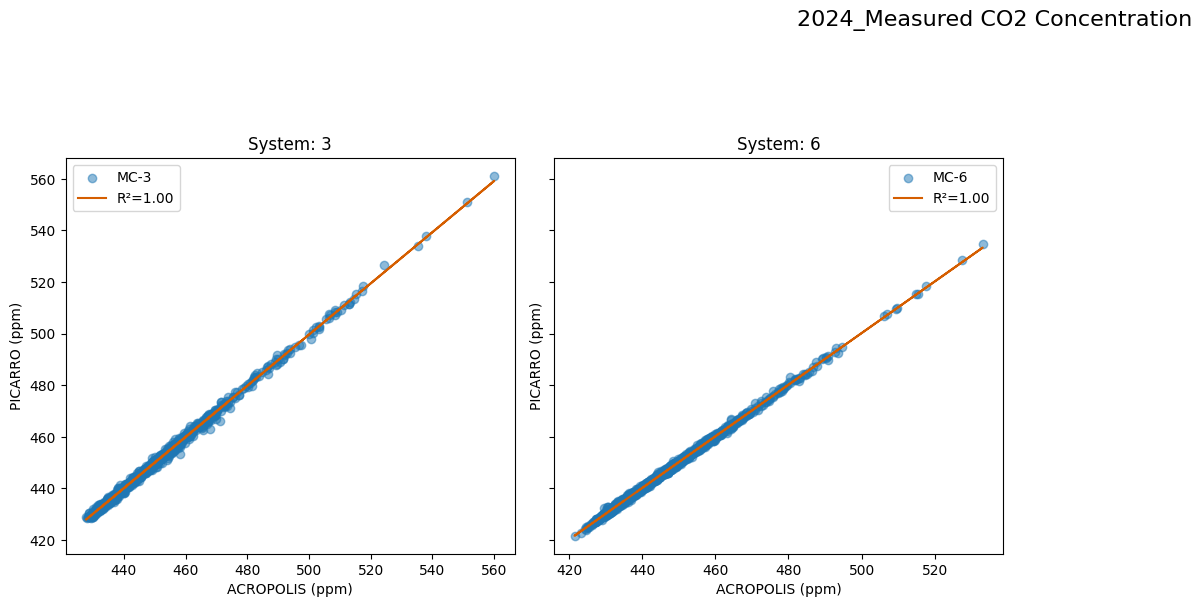

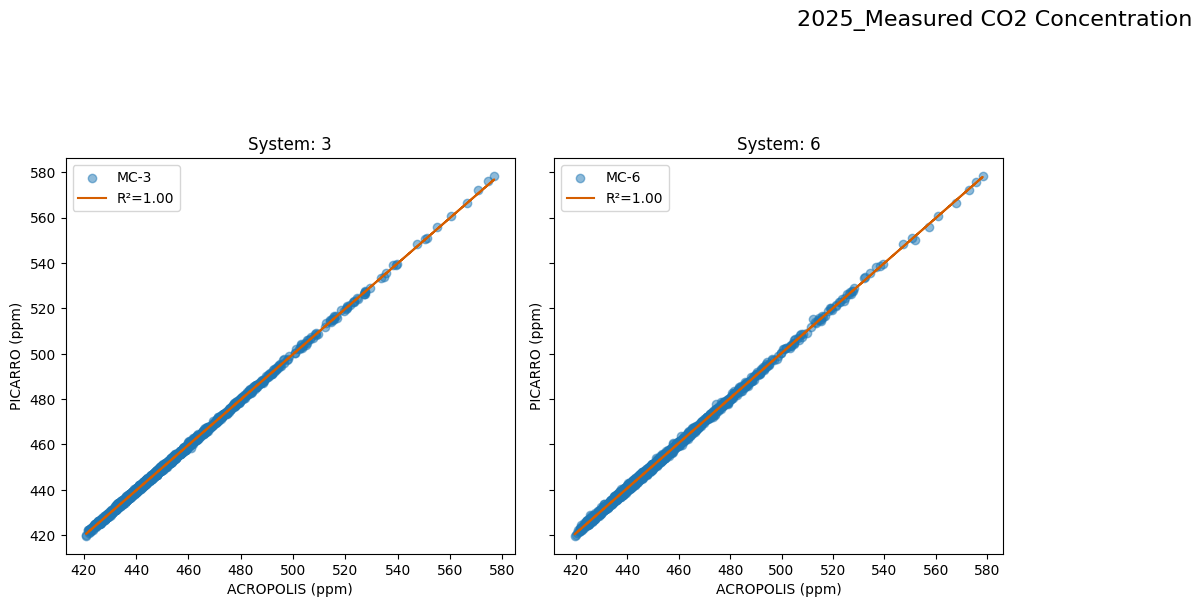

In [29]:
# parameters
x_col_name = "gmp343_corrected"
y_col_name = "picarro_corrected"
max_col = 4
max_row = 5
x_title = "ACROPOLIS (ppm)"
y_title = "PICARRO (ppm)"
title_text = "Measured CO2 Concentration" 

plot_scatter_with_trendline(df=df_2024, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text="2024_" + title_text)

x_col_name = column

plot_scatter_with_trendline(df=df, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text="2025_" +title_text)

In [30]:
def plot_scatter(
    df1: pl.DataFrame,
    df2: pl.DataFrame,
    years=(2024, 2025),
    system_id=3,
    y_col_name="y_name",
    y_title="y_title",
    y_lim=None,
    figsize=(10, 10),
    dpi=100
):
    dfs      = [df1, df2]
    yrs      = list(years)
    columns  = ["bme280_pressure", "h2o_v%", "gmp343_temperature"]
    x_titles = ["Inlet Pressure (hPa)", "Absolute Humidity (vol%)", "Temperature (°C)",]
    assert len(dfs) == len(yrs) == 2

    n_rows = len(columns)
    n_cols = len(yrs)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=figsize, dpi=dpi,
                             sharey=True, sharex=False)
    axes = np.array(axes).reshape(n_rows, n_cols)

    for i, (column, _) in enumerate(zip(columns, x_titles)):
        for j, df in enumerate(dfs):
            year = yrs[j]
            ax = axes[i, j]
            df_plot = df.filter(pl.col("system_id") == system_id)
            x = df_plot.select(column).to_numpy().flatten()
            y = df_plot.select(y_col_name).to_numpy().flatten()

            # ——— compute density for each point ———
            xy = np.vstack([x, y])
            z  = gaussian_kde(xy)(xy)
            idx = z.argsort()           # sort so densest are plotted last
            x, y, z = x[idx], y[idx], z[idx]

            # ——— plot colored points ———
            sc = ax.scatter(
                x, y,
                c=z,                    # one color per point
                cmap='cividis',         # or any other colormap
                s=25,                   # smaller markers
                edgecolor='black',
                linewidths=0.2, 
                alpha=0.7,
                label=f"n={len(x)}, id={system_id}",
            )

            # trendline & baseline
            if len(x) > 1:
                model = LinearRegression()
                model.fit(x.reshape(-1,1), y.reshape(-1,1))
                y_pred = model.predict(x.reshape(-1,1)).flatten()
                ax.plot(x, y_pred, color="#D55E00")
            ax.plot(x, np.zeros_like(x), '--', color='black')

            # only set column titles on the top row
            if i == 0:
                if system_id == 3:
                    col_title = (
                        f"18.02 - 31.05.{year} (v2)" if year == 2025
                        else f"13.01 - 19.02.{year} (v1)"
                    )
                    ax.set_title(col_title)
                if system_id == 6:
                    col_title = (
                        f"18.02 - 31.05.{year} (v2)" if year == 2025
                        else f"20.02 - 17.04.{year} (v1)"
                    )
                    ax.set_title(col_title)

            if j == 0:
                ax.set_ylabel(y_title)
            if y_lim is not None:
                ax.set_ylim(y_lim)
                
            ax.set_xlabel(x_titles[i])
            
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
            ax.legend()



    # shared legend for regression & baseline
    line_reg  = Line2D([0],[0], color="red",   label='Linear Regression')
    line_base = Line2D([0],[0], linestyle='--', color='black', label='Baseline (y = 0.0)')
    fig.legend(
        handles=[line_reg, line_base],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        ncol=2,
        frameon=False,
        fontsize=14,
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

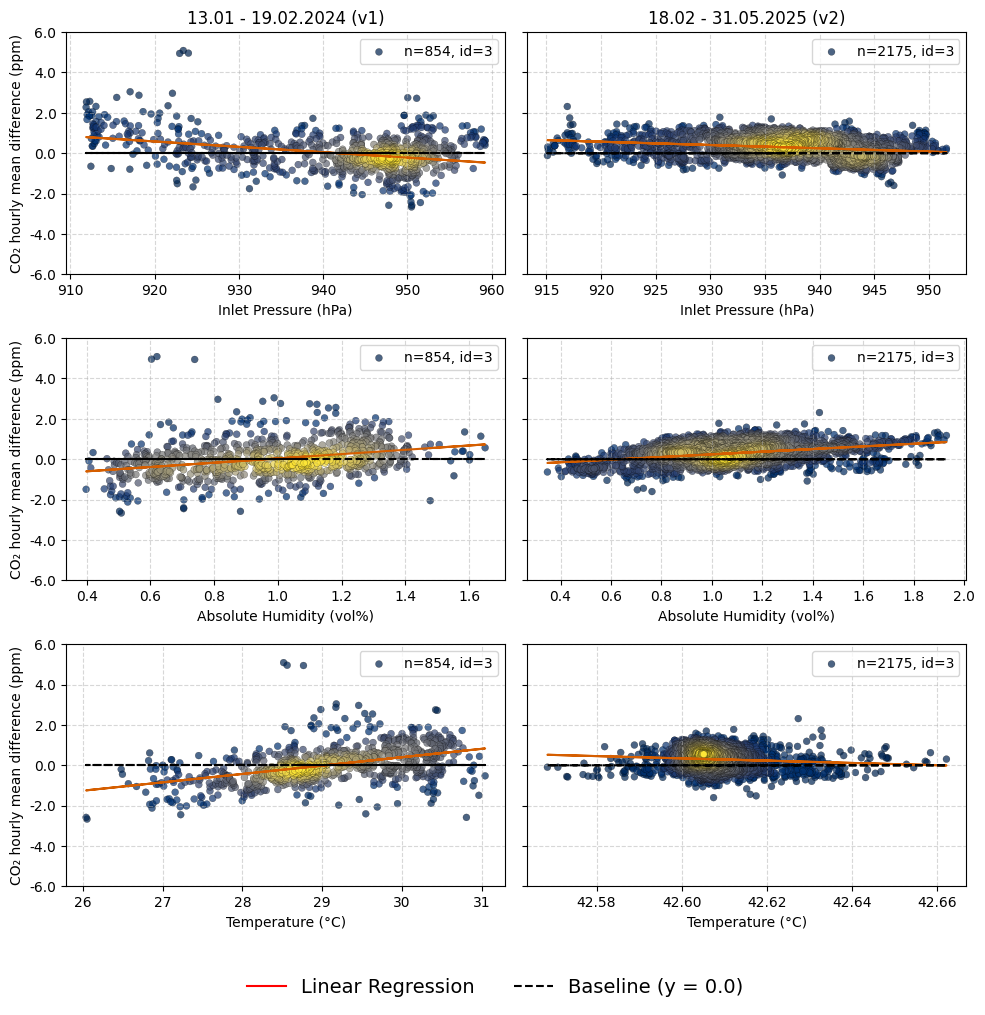

In [31]:
# parameters
y_col_name = "diff"
y_title = "CO₂ hourly mean difference (ppm)"

plot_scatter(
    df1=df_2024, 
    df2=df,
    system_id=3,
    years=(2024, 2025),
    y_col_name=y_col_name, 
    y_title = y_title, 
    y_lim=(-6, 6))

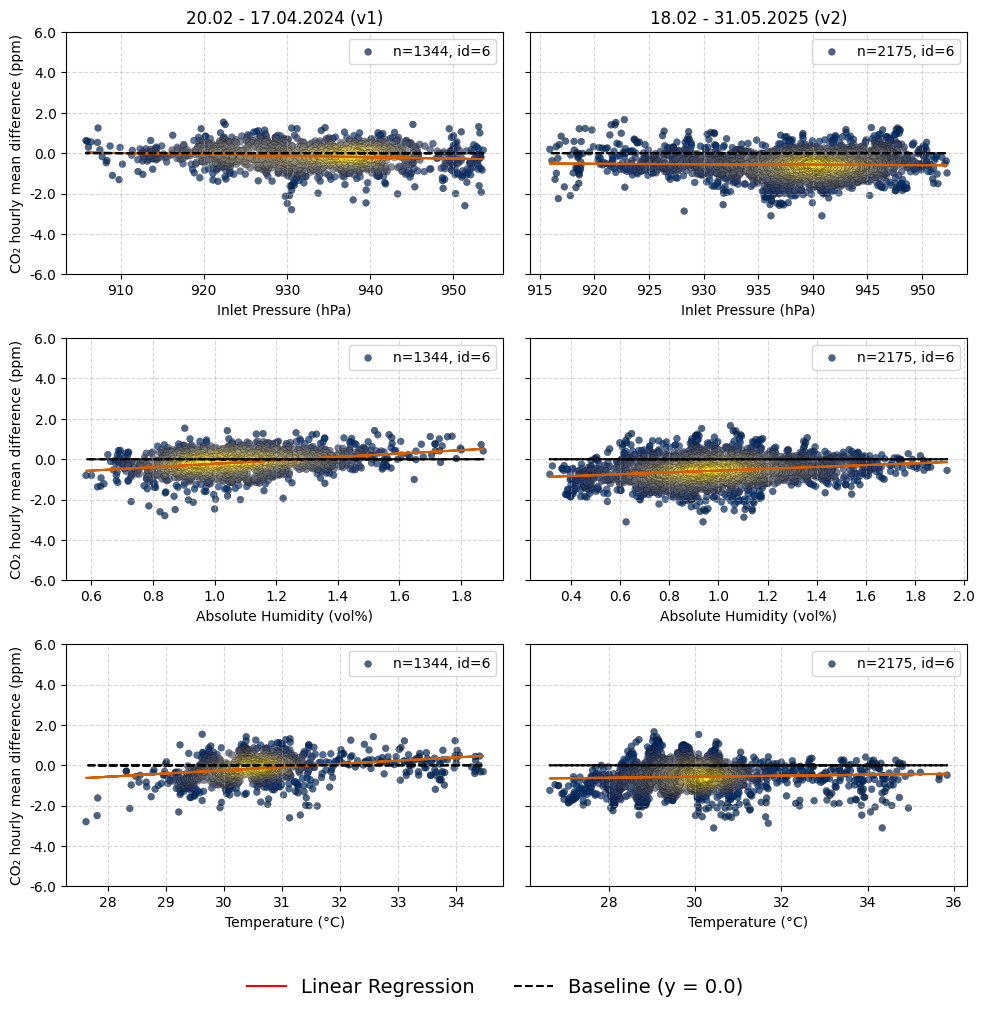

In [32]:
# parameters
y_col_name = "diff"
y_title = "CO₂ hourly mean difference (ppm)"

plot_scatter(
    df1=df_2024, 
    df2=df,
    system_id=6,
    years=(2024, 2025),
    y_col_name=y_col_name, 
    y_title = y_title, 
    y_lim=(-6, 6))

In [33]:
def plot_scatter(
    df1: pl.DataFrame,
    df2: pl.DataFrame,
    y_col_name="y_name",
    y_title="y_title",
    y_lim=None,
    figsize=(10, 10),
    dpi=100
):
    dfs      = [df1, df2]
    columns  = ["bme280_pressure", "h2o_v%", "gmp343_temperature"]
    x_titles = ["Inlet Pressure (hPa)", "Absolute Humidity (vol%)", "Temperature (°C)",]

    n_rows = len(columns)
    n_cols = len(dfs)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=figsize, dpi=dpi,
                             sharey=True, sharex=False)
    axes = np.array(axes).reshape(n_rows, n_cols)

    for i, (column, _) in enumerate(zip(columns, x_titles)):
        for j, df_plot in enumerate(dfs):
            ax = axes[i, j]
            x = df_plot.select(column).to_numpy().flatten()
            y = df_plot.select(y_col_name).to_numpy().flatten()
            system_id = df_plot.select("system_id").to_numpy().flatten()[0]

            # ——— compute density for each point ———
            xy = np.vstack([x, y])
            z  = gaussian_kde(xy)(xy)
            idx = z.argsort()           # sort so densest are plotted last
            x, y, z = x[idx], y[idx], z[idx]

            # ——— plot colored points ———
            sc = ax.scatter(
                x, y,
                c=z,                    # one color per point
                cmap='cividis',         # or any other colormap
                s=25,                   # smaller markers
                edgecolor='black',
                linewidths=0.2, 
                alpha=0.7,
                label=f"n={len(x)}, id={system_id}",
            )

            # trendline & baseline
            if len(x) > 1:
                model = LinearRegression()
                model.fit(x.reshape(-1,1), y.reshape(-1,1))
                y_pred = model.predict(x.reshape(-1,1)).flatten()
                ax.plot(x, y_pred, color="#D55E00")
            ax.plot(x, np.zeros_like(x), '--', color='black')

            # only set column titles on the top row
            if i == 0:
                if system_id == 3:
                    col_title = (f"06.06.- 06.07.2025 (v2)")
                    ax.set_title(col_title)
                if system_id == 6:
                    col_title = (f"06.06.- 06.07.2025 (v1)")
                    ax.set_title(col_title)

            if j == 0:
                ax.set_ylabel(y_title)
            if y_lim is not None:
                ax.set_ylim(y_lim)
                
            ax.set_xlabel(x_titles[i])
            
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
            ax.legend()



    # shared legend for regression & baseline
    line_reg  = Line2D([0],[0], color="red",   label='Linear Regression')
    line_base = Line2D([0],[0], linestyle='--', color='black', label='Baseline (y = 0.0)')
    fig.legend(
        handles=[line_reg, line_base],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        ncol=2,
        frameon=False,
        fontsize=14,
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

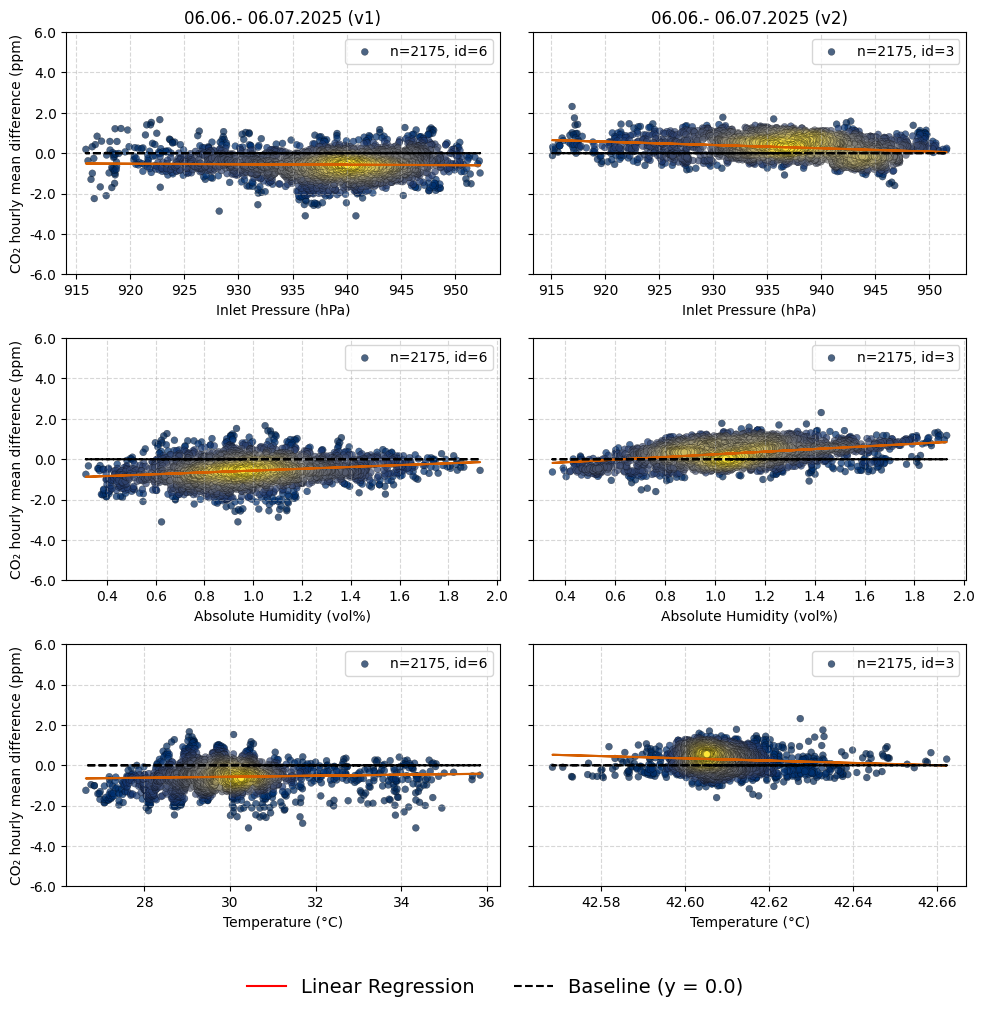

In [34]:
plot_scatter(
    df1=df.filter(pl.col("system_id") == 6), 
    df2=df.filter(pl.col("system_id") == 3),
    y_col_name="diff", 
    y_title = "CO₂ hourly mean difference (ppm)", 
    y_lim=(-6, 6))